In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# load dataset
data = pd.read_csv('Titanic-Dataset.csv')

# display first few rows
print(data.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
# Checking for missing values
print(data.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
# dataset information
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [10]:
# 1. classification task : survival prediction

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Droping irrelevant columns: PassengerId, Name, Ticket, Cabin
data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

# Handling missing values
data["Age"] = data["Age"].fillna(data["Age"].median())  # Fill missing 'Age' with median
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])  # Fill missing 'Embarked' with mode
data["Fare"] = data["Fare"].fillna(data["Fare"].median())  # Fill missing 'Fare' with median

# Converting categorical features to numerical
data["Sex"] = data["Sex"].map({"male": 0, "female": 1})

# One-hot encode 'Embarked' (no need to drop first, as it is binary)
data = pd.get_dummies(data, columns=["Embarked"], drop_first=True)

# Prepare X and y
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked_Q", "Embarked_S"]
target = "Survived"
X = data[features]
y = data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate Decision Tree model
y_pred_dt = dt_model.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


Decision Tree Accuracy: 0.7877
Random Forest Accuracy: 0.7989


In [12]:
# 2. feature comoplexity : handling different datatypes

from sklearn.preprocessing import StandardScaler

# Checking data types
print(data.dtypes)

# Scaling numerical features (only Age and Fare)
scaler = StandardScaler()
num_features = ["Age", "Fare"]
data[num_features] = scaler.fit_transform(data[num_features])

# Display processed dataset
print(data.head())


Survived        int64
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked_Q       bool
Embarked_S       bool
dtype: object
   Survived  Pclass  Sex       Age  SibSp  Parch      Fare  Embarked_Q  \
0         0       3    0 -0.565736      1      0 -0.502445       False   
1         1       1    1  0.663861      1      0  0.786845       False   
2         1       3    1 -0.258337      0      0 -0.488854       False   
3         1       1    1  0.433312      1      0  0.420730       False   
4         0       3    0  0.433312      0      0 -0.486337       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


Decision Tree Cross-Validation Score: 0.7958
Random Forest Cross-Validation Score: 0.8048


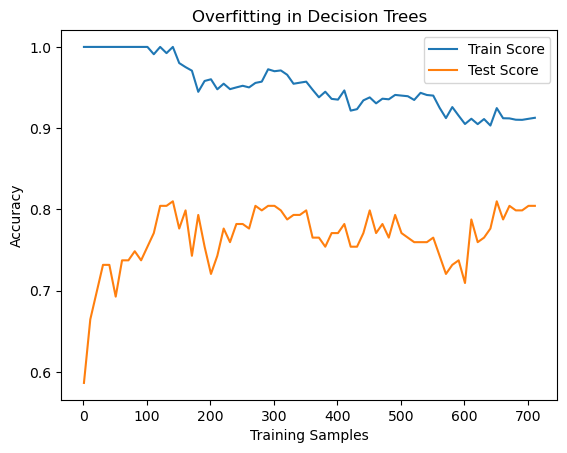

In [48]:
# 3. overfitting risk : decision tree vs random forest
from sklearn.model_selection import cross_val_score

# Evaluate Decision Tree with Cross-Validation
dt_scores = cross_val_score(dt_model, X, y, cv=10)
rf_scores = cross_val_score(rf_model, X, y, cv=10)

print(f"Decision Tree Cross-Validation Score: {dt_scores.mean():.4f}")
print(f"Random Forest Cross-Validation Score: {rf_scores.mean():.4f}")

# Visualizing Overfitting
train_sizes = range(1, len(X_train), 10)
train_scores, test_scores = [], []

for size in train_sizes:
    dt_model.fit(X_train[:size], y_train[:size])
    train_scores.append(dt_model.score(X_train[:size], y_train[:size]))
    test_scores.append(dt_model.score(X_test, y_test))

plt.plot(train_sizes, train_scores, label="Train Score")
plt.plot(train_sizes, test_scores, label="Test Score")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Overfitting in Decision Trees")
#plt.savefig("overfit_decisiontree.png", dpi=300)
plt.show()


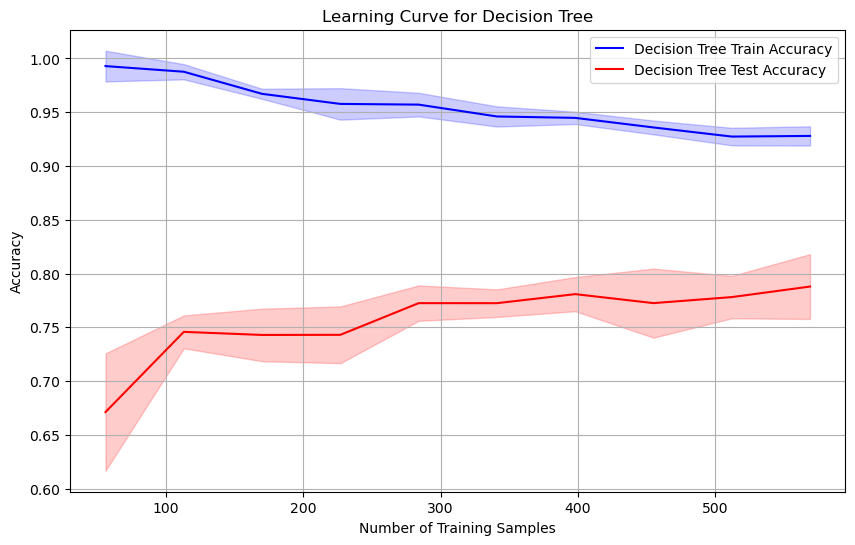

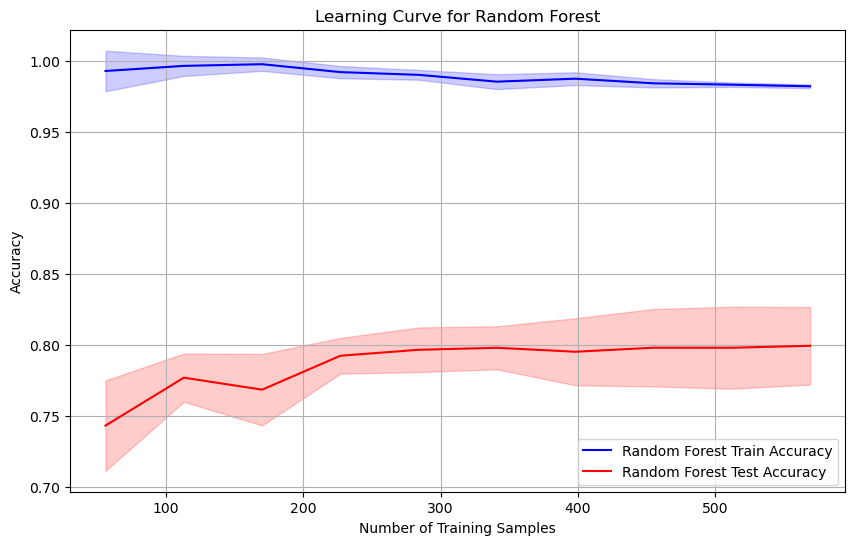

In [46]:
# 4. visualization overfitting : learning curves
from sklearn.model_selection import learning_curve

# Function to plot learning curves
def plot_learning_curve(model, X_train, y_train, model_name):
    # train_sizes as a percentage of total samples
    train_sizes = np.linspace(0.1, 1.0, 10)  # 10% to 100% of the training set
    
    # Compute learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, train_sizes=train_sizes, scoring="accuracy"
    )
    
    # Calculate the mean and standard deviation for the scores
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label=f'{model_name} Train Accuracy', color='blue')
    plt.plot(train_sizes, test_mean, label=f'{model_name} Test Accuracy', color='red')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='red')
    
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    
# Plot learning curves for Decision Tree
plot_learning_curve(dt_model, X_train, y_train, "Decision Tree")
#plt.savefig("learningcurve_decisiontree.png", dpi=300)

# Plot learning curves for Random Forest
plot_learning_curve(rf_model, X_train, y_train, "Random Forest")
#plt.savefig("learningcurve_randomforest.png", dpi=300)

plt.show()

In [18]:
# 5. hyperparameter tuning for Decision tree 
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy'], # The function to measure the quality of a split
}

# Initialize GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search_dt.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best cross-validation accuracy for Decision Tree:", grid_search_dt.best_score_)

# Train the best Decision Tree model
best_dt_model = grid_search_dt.best_estimator_

# Evaluate on test set
y_pred_dt_tuned = best_dt_model.predict(X_test)
print(f"Tuned Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt_tuned):.4f}")

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation accuracy for Decision Tree: 0.8230079779375554
Tuned Decision Tree Accuracy: 0.7989


In [20]:
# 6. hyperparameter tuning for Random forest

from sklearn.model_selection import GridSearchCV

# Set up hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

# Fit the model on training data
grid_search_rf.fit(X_train, y_train)

# Print best hyperparameters and corresponding score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)

# Get the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the tuned model on the test set
y_pred_rf_tuned = best_rf_model.predict(X_test)
tuned_rf_accuracy = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Tuned Random Forest Accuracy: {tuned_rf_accuracy:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy for Random Forest: 0.8286417807544566
Tuned Random Forest Accuracy: 0.8324


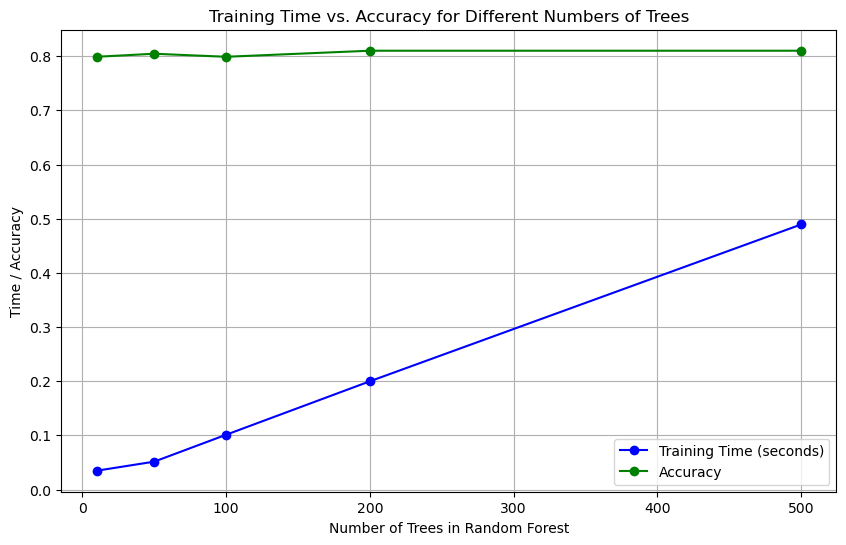

In [44]:
# 7. Training Time vs. Accuracy for Different Numbers of Trees in Random Forest
import time

# List of different numbers of trees to test
n_trees = [10, 50, 100, 200, 500]

# Store training times and accuracies
train_times = []
accuracies = []

# Evaluate Random Forest with different numbers of trees
for n in n_trees:
    # Initialize the Random Forest model with different number of trees
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Record the training time
    end_time = time.time()
    train_time = end_time - start_time
    
    # Predict and calculate accuracy
    y_pred_rf = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_rf)
    
    # Store results
    train_times.append(train_time)
    accuracies.append(accuracy)

# Plot Training Time vs Accuracy
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_times, label='Training Time (seconds)', marker='o', color='blue')
plt.plot(n_trees, accuracies, label='Accuracy', marker='o', color='green')
plt.xlabel('Number of Trees in Random Forest')
plt.ylabel('Time / Accuracy')
plt.title('Training Time vs. Accuracy for Different Numbers of Trees')
plt.legend()
plt.grid(True)
#plt.savefig("traintime_vs_accuracy.png", dpi=300)  
plt.show()


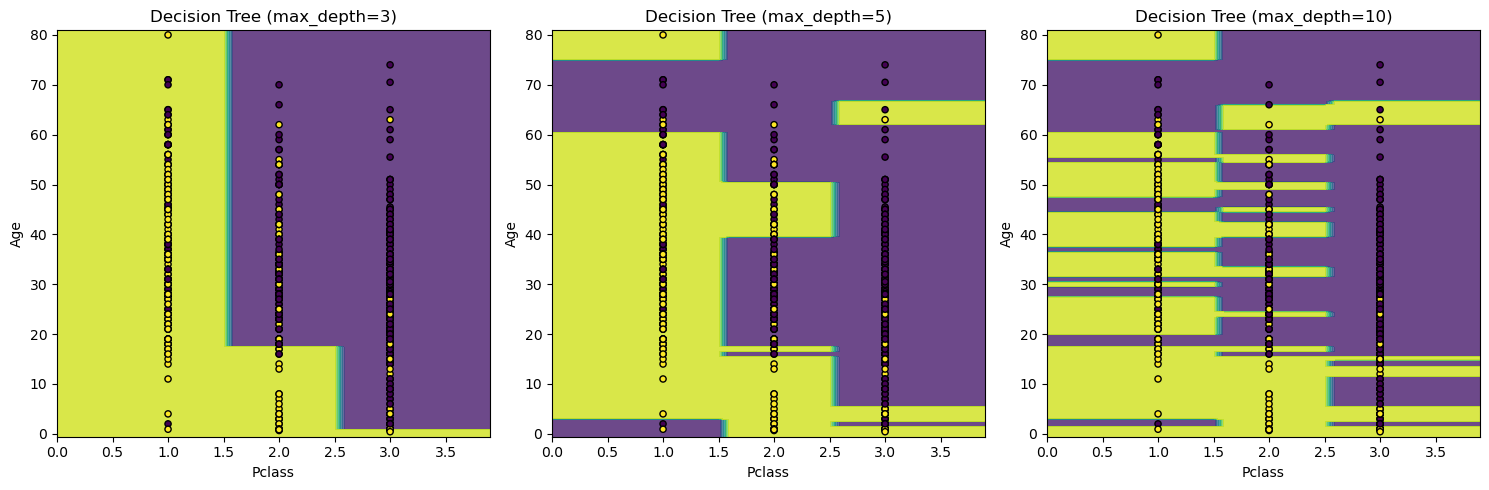

In [42]:
# 8. Visualizing Decision Boundaries for Different Depths of Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Select only two features for 2D visualization (e.g., Pclass, Age)
X_vis = X[["Pclass", "Age"]]
X_vis_train, X_vis_test, y_vis_train, y_vis_test = train_test_split(X_vis, y, test_size=0.2, random_state=42)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_vis["Pclass"].min() - 1, X_vis["Pclass"].max() + 1
y_min, y_max = X_vis["Age"].min() - 1, X_vis["Age"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Convert mesh grid to a pandas DataFrame with feature names
grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=["Pclass", "Age"])

# Visualize Decision Boundaries for different tree depths
depths = [3, 5, 10]
plt.figure(figsize=(15, 5))

for i, depth in enumerate(depths, start=1):
    # Fit Decision Tree model with the specific depth
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_vis_train, y_vis_train)
    
    # Predict on the grid of values
    Z = dt_model.predict(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.subplot(1, len(depths), i)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_vis["Pclass"], X_vis["Age"], c=y, edgecolors='k', marker='o', s=20)
    plt.title(f"Decision Tree (max_depth={depth})")
    plt.xlabel('Pclass')
    plt.ylabel('Age')

plt.tight_layout()
#plt.savefig("depth_of_decisiontree.png", dpi=300)  
plt.show()

